In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!git pull

Already up to date.


In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

from zoobot.active_learning import check_uncertainty, metrics, acquisition_utils

In [5]:
### Make predictions on DECALS (will be script?)

In [6]:
LOCAL = True

In [7]:
# QUESTION = 'bars'
QUESTION = 'smooth'

# NEW_PREDICTIONS = False
NEW_PREDICTIONS = True

### Get data on which to make predictions (only needed if local)

In [8]:
assert LOCAL

Shards live at /root/repos/zoobot/data/decals/shards/decals_smooth_may/eval_shards/s256_shard_{n}.tfrecord. These are never acquired, and reserved for testing. Also includes catalog eval_df.csv.

From AWS: aws s3 sync eval_shards s3://galaxy-zoo/active-learning/decals_smooth_may_eval_shards
From local: 

In [9]:
!aws s3 sync s3://galaxy-zoo/active-learning/decals_smooth_may_eval_shards decals_smooth_may_eval_shards

### Get a model (only needed if local)

On AWS: aws s3 sync ~/root/repos/zoobot/data/experiments/decals_smooth_may/iteration_6/estimators s3://galaxy-zoo/active-learning/decals_smooth_may_iteration_6_estimators

Locally (better in terminal): aws s3 sync s3://galaxy-zoo/active-learning/decals_smooth_may_iteration_6_estimators decals_smooth_may_iteration_6_estimators 

In [10]:
results_dir = 'estimators/decals_smooth_may_iteration_6_estimators'
model_name = '1566573780'

## Make predictions

In [11]:
tfrecord_dir = 'decals_smooth_may_eval_shards'
tfrecord_loc = [os.path.join(tfrecord_dir, x) for x in os.listdir(tfrecord_dir) if x.endswith('.tfrecord')]

In [12]:
# n_samples = 30
n_samples = 1
n_galaxies = 5000


In [13]:
save_dir = 'predictions/{}'.format(model_name)

In [14]:
if QUESTION == 'smooth':
    EXPECTED_VOTES = 40
elif QUESTION == 'bars':
    EXPECTED_VOTES = 10

In [15]:
images, id_strs, samples = check_uncertainty.calculate_predictions(
    tfrecord_loc,
    n_galaxies,
    results_dir,
    model_name,
    inital_size=256,
    n_samples=n_samples
)
assert samples.shape[1] == n_samples

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from estimators/decals_smooth_may_iteration_6_estimators/1566573780/variables/variables


INFO:tensorflow:Restoring parameters from estimators/decals_smooth_may_iteration_6_estimators/1566573780/variables/variables


In [ ]:
assert False

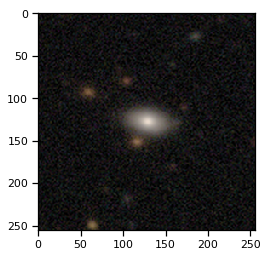

In [20]:
plt.imshow(images[0].astype('uint8'))

In [22]:
if not os.path.isdir('decals_smooth_may_eval_shards/test_images'):
    os.mkdir('decals_smooth_may_eval_shards/test_images')

In [24]:
from PIL import Image

In [29]:
# id_strs = [id_str.decode('utf-8') for id_str in id_strs]
galaxies = zip(id_strs, images)
for galaxy in galaxies:
    pil_im = Image.fromarray(galaxy[1].astype('uint8'))
#     plt.imshow(pil_im)
#     break
    pil_im.save('decals_smooth_may_eval_shards/test_images/{}.png'.format(galaxy[0]))

In [102]:
subjects = [{'matrix': images[n], 'id_str': id_strs[n].decode('utf-8')} for n in range(len(id_strs))]
# acquisitions = acquisition_utils.mutual_info_acquisition_func(samples, expected_votes=EXPECTED_VOTES)
# metrics.save_iteration_state(save_dir, subjects, samples, acquisitions=acquisitions)

In [1]:
eval_df = pd.read_csv('decals_smooth_may_eval_shards/eval_df.csv')

NameError: name 'pd' is not defined

In [104]:
eval_df['iauname']

0       J151023.19+020737.5
1       J015708.34+122855.0
2       J091427.67+073429.7
3       J141021.96+020037.9
4       J025835.45-075405.0
               ...         
4995    J020609.10+000137.0
4996    J132649.77+010307.4
4997    J105847.32+103337.9
4998    J101018.04+023719.1
4999    J102333.96+060249.7
Name: iauname, Length: 5000, dtype: object

In [105]:
prediction_data = [{'iauname': id_strs[n].decode('utf-8'), 'predictions': samples[n][:]} for n in range(len(id_strs))]

In [106]:
predictions = pd.DataFrame(data=prediction_data)

In [107]:
predictions = pd.merge(predictions, eval_df, how='inner', on='iauname')

In [108]:
predictions['median_prediction'] = predictions['predictions'].apply(lambda x: np.median(x))

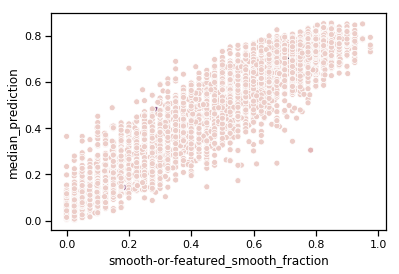

In [110]:
sns.scatterplot(data=predictions, x='smooth-or-featured_smooth_fraction', y='median_prediction', hue='smooth-or-featured_total-votes', legend=False)

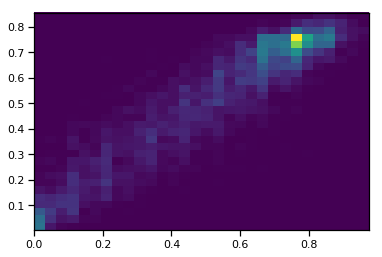

In [115]:
_ = plt.hist2d(predictions['smooth-or-featured_smooth_fraction'], predictions['median_prediction'], bins=[30, 30])

In [111]:
len(eval_df)

5000

In [112]:
# predictions.to_parquet('decals_may_test_set_predictions.parquet')

### Temp - make any temporary tweaks needed for end users

In [3]:
!ls *.parquet

bars_test_predictions_and_gz2_catalog.parquet
decals_may_test_set_predictions.parquet
smooth_test_predictions_and_gz2_catalog.parquet


In [14]:
import shutil
import os
import pandas as pd

In [5]:
predictions = pd.read_parquet('decals_may_test_set_predictions.parquet')

In [6]:
predictions.columns.values

array(['iauname', 'predictions', 'Unnamed: 0', 'index', 'nsa_id', 'ra',
       'dec', 'petrotheta', 'petroth50', 'petroth90', 'redshift',
       'local_fits_loc', 'local_png_loc', 'fits_ready', 'fits_filled',
       'png_ready', 'nsa_version', 'file_loc', 'subject_id',
       'smooth-or-featured_artifact',
       'smooth-or-featured_featured-or-disk', 'smooth-or-featured_smooth',
       'how-rounded_round', 'how-rounded_in-between',
       'how-rounded_cigar-shaped', 'disk-edge-on_yes', 'disk-edge-on_no',
       'edge-on-bulge_rounded', 'edge-on-bulge_boxy',
       'edge-on-bulge_none', 'bar_strong', 'bar_weak', 'bar_no',
       'has-spiral-arms_yes', 'has-spiral-arms_no',
       'spiral-winding_tight', 'spiral-winding_medium',
       'spiral-winding_loose', 'spiral-arm-count_1', 'spiral-arm-count_2',
       'spiral-arm-count_3', 'spiral-arm-count_4',
       'spiral-arm-count_more-than-4', 'spiral-arm-count_cant-tell',
       'bulge-size_none', 'bulge-size_small', 'bulge-size_moderate'

In [8]:
predictions['local_png_loc']

0       /Volumes/alpha/decals/png_native/dr5/J111/J111...
1       /Volumes/alpha/decals/png_native/dr5/J084/J084...
2       /Volumes/alpha/decals/png_native/dr5/J214/J214...
3       /Volumes/alpha/decals/png_native/dr5/J114/J114...
4       /Volumes/alpha/decals/png_native/dr5/J015/J015...
                              ...                        
4995    /Volumes/alpha/decals/png_native/dr5/J090/J090...
4996    /Volumes/alpha/decals/png_native/dr5/J120/J120...
4997    /Volumes/alpha/decals/png_native/dr5/J015/J015...
4998    /Volumes/alpha/decals/png_native/dr5/J104/J104...
4999    /Volumes/alpha/decals/png_native/dr5/J103/J103...
Name: local_png_loc, Length: 5000, dtype: object

In [9]:
!mkdir predictions/test_set_galaxies

In [16]:
predictions['local_png_loc'].apply(lambda x: shutil.copyfile(x, os.path.join('predictions/test_set_galaxies', x.split('/')[-1])))

0       predictions/test_set_galaxies/J111533.15+03252...
1       predictions/test_set_galaxies/J084726.12+05461...
2       predictions/test_set_galaxies/J214338.91-08432...
3       predictions/test_set_galaxies/J114742.54+02165...
4       predictions/test_set_galaxies/J015606.45+12340...
                              ...                        
4995    predictions/test_set_galaxies/J090448.58+02512...
4996    predictions/test_set_galaxies/J120316.07+08514...
4997    predictions/test_set_galaxies/J015324.92+00375...
4998    predictions/test_set_galaxies/J104512.85+06440...
4999    predictions/test_set_galaxies/J103926.18+04202...
Name: local_png_loc, Length: 5000, dtype: object

In [17]:
del predictions['local_png_loc']
del predictions['local_fits_loc']
del predictions['Unnamed: 0']

In [18]:
predictions.to_csv('predictions/test_set_galaxies/test_set_predictions_for_molly.csv', index=False)

In [29]:
mkdir /data/Onedrive/Shared/molly

In [31]:
!cp -r predictions/test_set_galaxies /data/Onedrive/Shared/molly/test_set_galaxies

### Temp - repeat for Molly

In [10]:
df = pd.read_csv('molly_galaxies.csv', sep='\t')
df = df.rename(columns={'Galaxy Number': 'id_str', 'SDSS ID': 'sdss_id', 'RA': 'ra', 'Dec ': 'dec'})
df['id_str'] = df['id_str'].astype(str)

In [11]:
df.head()

,id_str,sdss_id,ra,dec
0,1,1237648720142336185,146.512839,-0.845780
1,2,1237648721215815838,145.877377,-0.050183
2,3,1237648721215946942,146.299852,-0.119996
3,4,1237648721216078045,146.468900,-0.092827
4,5,1237648721216078463,146.594466,-0.133156


In [12]:
df['file_loc'] = df['id_str'].apply(lambda x: '/data/repos/zoobot/notebooks/molly_galaxies/Galaxy_{}.jpeg'.format(x))

In [13]:
assert all([os.path.isfile(loc) for loc in df['file_loc']])

In [14]:
from PIL import Image

In [15]:
from zoobot.tfrecord import catalog_to_tfrecord

In [16]:
def reader(galaxy, crop=50):
    loc = galaxy['file_loc']
    raw_image = Image.open(loc)
    return raw_image.crop((50, 50, raw_image.size[0] - crop, raw_image.size[0] - crop))

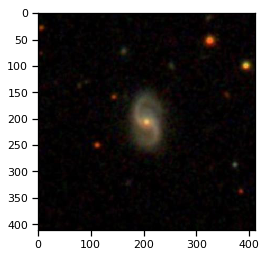

In [17]:
image = reader(df.iloc[0])
plt.imshow(image)

In [18]:
save_dir = 'predictions/molly'
tfrecord_loc = '/data/repos/zoobot/notebooks/molly_galaxies/galaxies.tfrecord'

In [19]:
columns_to_save = ['ra', 'dec', 'id_str']
img_size = 256

In [103]:
catalog_to_tfrecord.write_image_df_to_tfrecord(df, tfrecord_loc, img_size, columns_to_save, reader, append=False)

100%|██████████| 22/22 [00:00<00:00, 97.29 subjects saved/s]


In [23]:
n_galaxies = len(df)
n_samples = 30

In [24]:
images, id_strs, samples = check_uncertainty.calculate_predictions(
    tfrecord_loc,
    n_galaxies,
    results_dir,
    model_name,
    inital_size=256,
    n_samples=n_samples
)

INFO:tensorflow:Restoring parameters from estimators/decals_smooth_may_iteration_6_estimators/1566573780/variables/variables


INFO:tensorflow:Restoring parameters from estimators/decals_smooth_may_iteration_6_estimators/1566573780/variables/variables


In [28]:
id_strs = [x.decode('utf-8') for x in id_strs]

In [31]:
df['predictions'] = samples.mean(axis=1)  # looks like it aligns

In [53]:
df['predictions_var'] = np.var(samples, axis=1)

In [55]:
df.to_csv('molly_predictions.csv', index=False)

In [36]:
images[n].shape

(256, 256, 3)

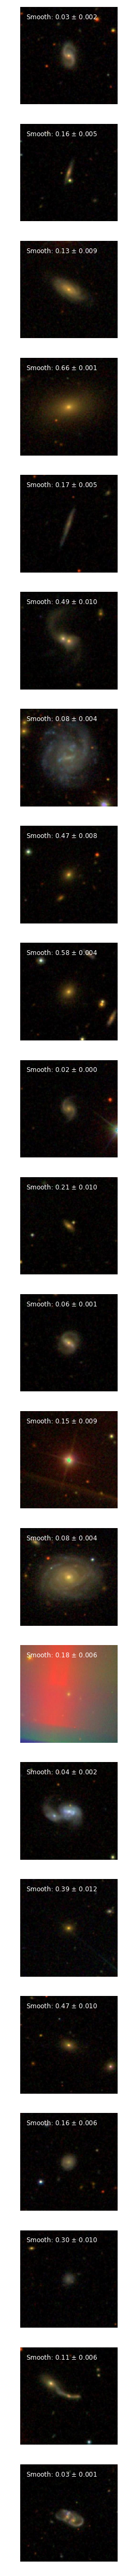

In [52]:
fig, axes = plt.subplots(nrows=len(df), figsize=(8, len(df) * 4))
for n, ax in enumerate(axes):
    ax.imshow(reader(df.iloc[n]))
    ax.text(25, 50, s=r'Smooth: {:.2f} $\pm$ {:.3f}'.format(samples[n].mean(), 3*np.var(samples[n])), color='white')
    ax.axis('off')
fig.savefig('molly_results.pdf')
    

In [32]:
# images, id_strs, samples

In [33]:
import matplotlib.gridspec as gridspec

In [ ]:
gr = gridspec.GridSpec(4, 4, wspace=0.0, hspace=0.0)